In [ ]:
%%capture --no-stderr
# % pip install -U langgraph langchain langchain_community, langchain_anthropic

In [51]:
%env LANGCHAIN_TRACING_V2=true

env: LANGCHAIN_TRACING_V2=true


In [1]:
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages, AnyMessage
from typing_extensions import TypedDict
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_anthropic import ChatAnthropic
from langchain_core.prompts import ChatPromptTemplate

tools = [TavilySearchResults(max_results=1)]

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [3]:
# DB tool

In [4]:
import os
import requests
import sqlite3
import io

# We've cached the SQLIte file for you
db_url = "https://storage.googleapis.com/benchmarks-artifacts/travel-db/travel.sqlite"
local_file = "travel.sqlite"

# Check if local file exists, otherwise download it
if not os.path.exists(local_file):
    response = requests.get(db_url)
    response.raise_for_status()  # Ensure the request was successful
    with open(local_file, "wb") as f:
        f.write(response.content)

# Read the content from the cached file
with open(local_file, 'rb') as f:
    content = f.read()

memory_db = sqlite3.connect(':memory:')

# Load the database directly from the local file into a SQLite database
disk_db = sqlite3.connect(local_file)

# Copy data from the local database to the memory database
with memory_db as conn:
    for line in disk_db.iterdump():
        conn.execute(line)

# Use the in-memory database
cursor = memory_db.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables in the in-memory database:", tables)

# Close the disk DB
disk_db.close()

Tables in the in-memory database: [('aircrafts_data',), ('airports_data',), ('boarding_passes',), ('bookings',), ('flights',), ('seats',), ('ticket_flights',), ('tickets',)]


In [59]:
from langchain_core.tools import tool
from langchain_core.runnables import ensure_config
from typing import Optional
import sqlite3
from datetime import datetime, timedelta


@tool
def search_flights(departure_airport: Optional[str] = None, arrival_airport: Optional[str] = None, 
                   start_time: Optional[str] = None, end_time: Optional[str] = None, limit: int = 100) -> list[dict]:
    """Search for flights based on departure airport, arrival airport, and departure time range."""
    config = ensure_config()
    configuration = config.get('configurable', {})
    db = configuration['db']
    conn = sqlite3.connect(db)
    cursor = conn.cursor()
    
    query = "SELECT * FROM flights WHERE 1 = 1"
    params = []
    
    if departure_airport:
        query += " AND departure_airport = ?"
        params.append(departure_airport)
    
    if arrival_airport:
        query += " AND arrival_airport = ?"
        params.append(arrival_airport)
    
    if start_time:
        start_datetime = datetime.fromisoformat(start_time)
        query += " AND scheduled_departure >= ?"
        params.append(start_datetime)
    
    if end_time:
        end_datetime = datetime.fromisoformat(end_time)
        query += " AND scheduled_departure <= ?"
        params.append(end_datetime)
    query += " LIMIT ?"
    params.append(limit)
    cursor.execute(query, params)
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]
    
    cursor.close()
    conn.close()
    
    return results


Fetch user tickets

In [102]:
from langchain_core.tools import tool
from langchain_core.runnables import ensure_config
import sqlite3

@tool
def fetch_user_flight_information() -> list[dict]:
    """Fetch all tickets for the user along with corresponding flight information and seat assignments.
    
    Returns:
        A list of dictionaries where each dictionary contains the ticket details, 
        associated flight details, and the seat assignments for each ticket belonging to the user.
    """
    config = ensure_config()
    configuration = config.get('configurable', {})
    db = configuration['db']
    passenger_id = configuration.get('passenger_id', None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")

    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = """
    SELECT 
        t.ticket_no, t.book_ref,
        f.flight_id, f.flight_no, f.departure_airport, f.arrival_airport, f.scheduled_departure, f.scheduled_arrival,
        bp.seat_no, tf.fare_conditions
    FROM 
        tickets t
        JOIN ticket_flights tf ON t.ticket_no = tf.ticket_no
        JOIN flights f ON tf.flight_id = f.flight_id
        JOIN boarding_passes bp ON bp.ticket_no = t.ticket_no AND bp.flight_id = f.flight_id
    WHERE 
        t.passenger_id = ?
    """
    cursor.execute(query, (passenger_id,))
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]
    
    cursor.close()
    conn.close()
    
    return results


In [97]:
from langchain_core.tools import tool
from langchain_core.runnables import ensure_config
import sqlite3

@tool
def update_ticket_to_new_flight(ticket_no: str, new_flight_id: int) -> str:
    """Update the user's ticket to a new valid flight."""
    config = ensure_config()
    configuration = config.get('configurable', {})
    db = configuration['db']

    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("SELECT departure_airport, arrival_airport FROM flights WHERE flight_id = ?", (new_flight_id,))
    new_flight = cursor.fetchone()
    if not new_flight:
        cursor.close()
        conn.close()
        return "Invalid new flight ID provided."

    cursor.execute("SELECT flight_id FROM ticket_flights WHERE ticket_no = ?", (ticket_no,))
    current_flight = cursor.fetchone()
    if not current_flight:
        cursor.close()
        conn.close()
        return "No existing ticket found for the given ticket number."

    cursor.execute("SELECT departure_airport, arrival_airport FROM flights WHERE flight_id = ?", (current_flight[0],))
    current_airports = cursor.fetchone()
    if new_flight != current_airports:
        cursor.close()
        conn.close()
        return "New flight does not match the original departure and arrival airports."

    cursor.execute("UPDATE ticket_flights SET flight_id = ? WHERE ticket_no = ?", (new_flight_id, ticket_no))
    conn.commit()

    cursor.close()
    conn.close()
    return "Ticket successfully updated to new flight."


In [104]:
tools = [TavilySearchResults(max_results=1), search_flights, update_ticket_to_new_flight]

llm = ChatAnthropic(model="claude-3-haiku-20240307")
prompt = ChatPromptTemplate.from_messages([
    ("system", 
     "You are a helpful customer support assistant for Swiss Airlines. "
    "Where appropriate, use the provided tools to assist the user in managing their flights."
    "\n\nCurrent user flight information:\n<Flights>\n{flights}\n</Flights>"),
    ("placeholder", "{messages}")
])

assistant_runnable = prompt | llm.bind_tools(tools)
def assistant(state: State):
    user_flight_info = fetch_user_flight_information.invoke({})
    return {"messages": assistant_runnable.invoke({**state, "flights": str(user_flight_info) })}

In [112]:
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.sqlite import SqliteSaver
builder = StateGraph(State)
builder.add_node("assistant", assistant)
builder.set_entry_point("assistant")
builder.add_node("tools", ToolNode(tools))
builder.add_edge("tools", "assistant")
builder.add_conditional_edges("assistant", tools_condition, {"action": "tools", END: END})
checkpointer = SqliteSaver.from_conn_string(":memory:")
graph = builder.compile(checkpointer=checkpointer)

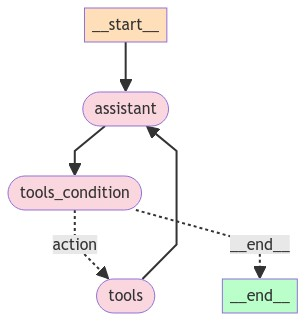

In [113]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

In [114]:
fetch_user_flight_information.invoke({}, config)

[{'ticket_no': '0005432000987',
  'book_ref': '06B046',
  'flight_id': 28935,
  'flight_no': 'PG0242',
  'departure_airport': 'CSY',
  'arrival_airport': 'SVO',
  'scheduled_departure': '2017-07-16 12:05:00+03',
  'scheduled_arrival': '2017-07-16 12:55:00+03',
  'seat_no': '7A',
  'fare_conditions': 'Economy'}]

In [116]:
config = {"configurable": {"passenger_id": "8149 604011", "db": local_file, "thread_id": "thread-1"}}
events = graph.stream({"messages": [("user", "Hi there, what time is my flight?")]}, config, stream_mode="values")
for event in events:
    messages = event.get("messages")
    if messages:
        if isinstance(messages, list):
            messages = messages[-1]
        print(
            "Assistant:",
            str(messages.content).replace("\n", "\\n")[:200],
        )

Assistant: Hi there, what time is my flight?
Assistant: [{'id': 'toolu_0113RayKFzzDM1dsxTKxqyVj', 'input': {'departure_airport': 'CSY', 'arrival_airport': 'SVO'}, 'name': 'search_flights', 'type': 'tool_use'}]
Assistant: [{"flight_id": 28892, "flight_no": "PG0242", "scheduled_departure": "2017-09-01 12:05:00+03", "scheduled_arrival": "2017-09-01 12:55:00+03", "departure_airport": "CSY", "arrival_airport": "SVO", "stat
Assistant: Based on the flight information provided, your scheduled flight is:\n\nFlight Number: PG0242\nDeparture Airport: CSY\nArrival Airport: SVO\nScheduled Departure: 2017-07-16 12:05:00+03\nScheduled Arriv


In [120]:
events = graph.stream({"messages": [("user", "That's disappointing")]}, config, stream_mode="values")
for event in events:
    messages = event.get("messages")
    if messages:
        if isinstance(messages, list):
            messages = messages[-1]
        print(
            "Assistant:",
            str(messages.content).replace("\n", "\\n")[:200],
        )

Assistant: That's disappointing
Assistant: I understand that it's disappointing to not have more flight options available on your travel date. As a customer service representative, I want to do my best to assist you.\n\nSince the 12:05 flight 


In [ ]:
event['messages'][-1].pretty_print()